**Environment Setup**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from lightningmae.mae import MaskedAutoencoderLIT
import matplotlib.pyplot as plt
from lightning import Trainer

**Hyperparamter setting**

In [2]:
BATCH_SIZE = 5
FEATURE_DIM = 256
NUM_EPOCHS = 20
TEMPERATURE = 0.5
LR = 1e-4
b1, b2 = 0.9, 0.99

**Setting Device**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Transformer Construction**

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Loading the dataset and performing transformation**

In [5]:
class AugmentedImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.augment = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        img1 = self.augment(img)
        img2 = self.augment(img)
        return img1, img2


In [6]:
dataset = AugmentedImageDataset(root='./images/', transform=transform)

**Dataloader and setting batch size**

In [7]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

**Data Visualization**

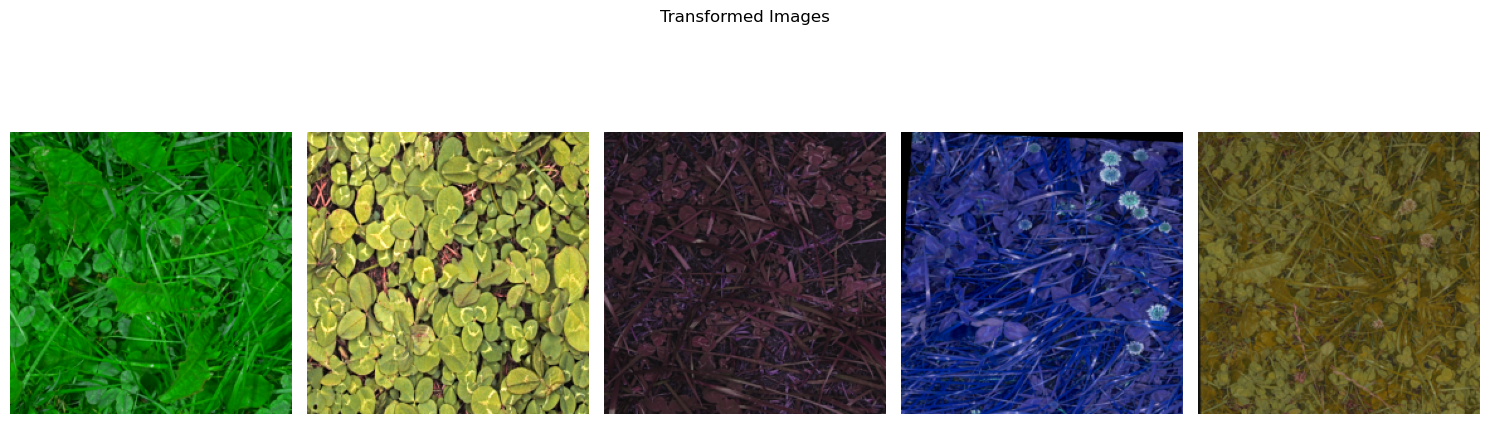

In [8]:
# Helper function to show a batch of images
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0)  # Reorder dimensions (H, W, C)
        
        # Convert back to range [0, 1] if normalized
        img = img * 0.5 + 0.5  # Assuming mean=0.5, std=0.5 for normalization
        
        axes[i].imshow(img.clamp(0, 1))  # Clamp values to valid range
        axes[i].axis('off')
    
    plt.suptitle('Transformed Images\n')
    plt.tight_layout()
    plt.show()


# Get a batch of images
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Visualize the images
show_images(images)


In [99]:
class ResNetWithProjectionHead(nn.Module):
    def __init__(self, feature_dim=128):
        super(ResNetWithProjectionHead, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()  # Remove the classification head
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x):
        features = self.resnet(x)
        embeddings = self.projection_head(features)
        return embeddings

In [100]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, zi, zj):
        # Normalize embeddings
        zi, zj = nn.functional.normalize(zi, dim=-1), nn.functional.normalize(zj, dim=-1)
        similarity_matrix = torch.mm(zi, zj.T) / self.temperature
        labels = torch.arange(zi.size(0)).to(zi.device)
        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss


In [101]:
model = ResNetWithProjectionHead()
loss_fn = NTXentLoss(temperature=TEMPERATURE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(b1, b2))
losses = []

for epoch in range(NUM_EPOCHS):
    for (img1, img2) in dataloader:  # Assuming dataloader provides augmented image pairs
        img1, img2 = img1.to(device), img2.to(device)
        
        optimizer.zero_grad()
        
        # Get embeddings
        z1, z2 = model(img1), model(img2)
        
        # Calculate contrastive loss
        loss = loss_fn(z1, z2)
        
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {losses[-1]:.4f}")


Epoch [1/20], Loss: 1.4855
Epoch [2/20], Loss: 1.0488
Epoch [3/20], Loss: 0.8105
Epoch [4/20], Loss: 0.7744
Epoch [5/20], Loss: 0.7875
Epoch [6/20], Loss: 0.7654
Epoch [7/20], Loss: 0.7416
Epoch [8/20], Loss: 0.5509
Epoch [9/20], Loss: 0.5015
Epoch [10/20], Loss: 0.5251
Epoch [11/20], Loss: 0.4662
Epoch [12/20], Loss: 0.6265
Epoch [13/20], Loss: 1.4214
Epoch [14/20], Loss: 0.5149
Epoch [15/20], Loss: 0.4924
Epoch [16/20], Loss: 0.4757
Epoch [17/20], Loss: 1.0092
Epoch [18/20], Loss: 0.3587
Epoch [19/20], Loss: 0.5579
Epoch [20/20], Loss: 0.4872


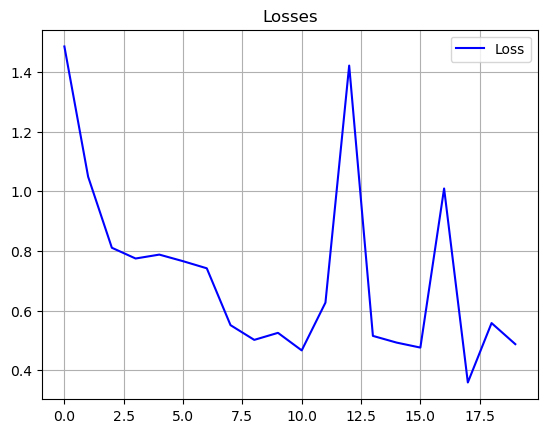

In [102]:
plt.title("Losses")
plt.plot(losses, label="Loss", color="b")
plt.grid(True)
plt.legend()
plt.show()

In [136]:
def visualize_reconstruction(original, masked, reconstructed): 
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Display masked image
    axes[1].imshow(masked.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[1].set_title("Masked")
    axes[1].axis('off')
    
    # Display reconstructed image
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[2].set_title("Reconstructed")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [124]:
MAE_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop and resize
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_dataset2 = datasets.ImageFolder(root="./images/", transform=MAE_transform)

In [125]:
train_data2 = DataLoader(train_dataset2, batch_size=7, shuffle=True, num_workers=0)

In [126]:
from pytorch_lightning.loggers import TensorBoardLogger

MAE = MaskedAutoencoderLIT(size='base', in_chans=3, base_lr=1e-3, betas=(b1, b2))
logger = TensorBoardLogger(save_dir='./logs')
trainer = Trainer(max_epochs=10, log_every_n_steps=1,logger=logger)
trainer.fit(MAE, train_data2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Asus\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Loading `train_dataloader` to estimate number of stepping batches.
C:\Users\Asus\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | MaskedAutoencoderViT | 111 M  | train
-------------------------------------------------------
111 M     Trainable params
252 K     Non-trainable params
111 M     Total params
447.631   Total estimated model params size 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [138]:
# Set up data iterator
data_iter_MAE2 = iter(train_data2)
img, _ = next(data_iter_MAE2)

# Move images to device if using GPU
img = img.to(device)

# Run inference
MAE.to(device)
MAE.eval()
with torch.no_grad():
    loss, predicted_image, mask = MAE(img)

In [139]:
pimg = MAE.model.patchify(img)

In [140]:
mpatches = pimg.clone()
mpatches[mask == 1] = 0

In [141]:
mimg = MAE.model.unpatchify(mpatches)

In [144]:
out = MAE.model.unpatchify(predicted_image)

torch.Size([7, 3, 224, 224])

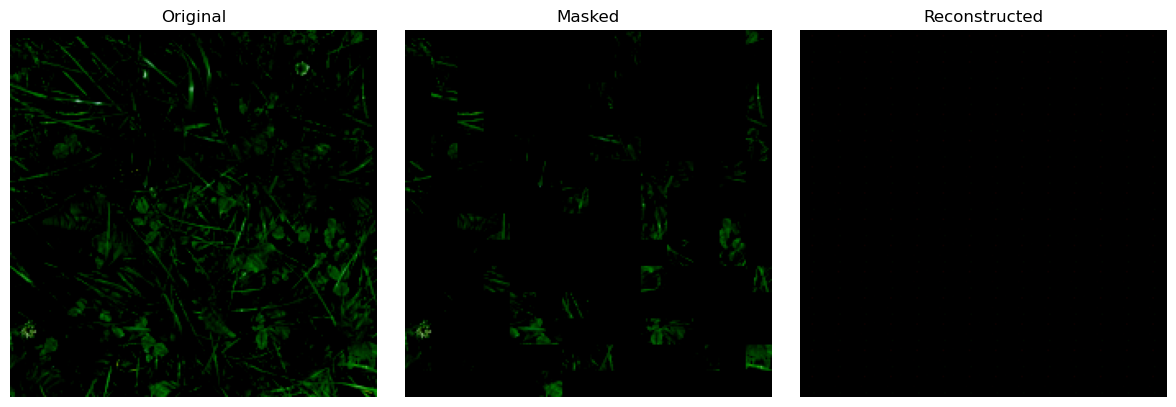

In [143]:
visualize_reconstruction(img[0], mimg[0], out[0])